# Automatic image classification (CNN approach with Hyperopt)
Pierre-Yves BOISBUNON - November 2018

----------

In this notebook, we will rework previously cross validation kernel using Hyperopt.

In [1]:
import os
import cv2
import math
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import GridSearchCV, RepeatedKFold, KFold
import pandas as pd
import shutil
import numpy as np
from sklearn.metrics import f1_score, confusion_matrix
import seaborn as sn

In [2]:
seed = 7
np.random.seed(seed)

In [3]:
# Disable GPU as my GPU card does not contain enough memory
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

In [4]:
from keras.applications.vgg16 import VGG16
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from keras.models import Sequential, Model
from keras.layers import Dropout, Flatten, Dense
from keras import applications
from keras import optimizers
from keras.utils import to_categorical
from keras import backend as K
from keras import callbacks
from keras.preprocessing.image import img_to_array, array_to_img
from keras.wrappers.scikit_learn import KerasClassifier
from keras import regularizers

C:\Users\boisb\Anaconda3\envs\py36\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [5]:
from tensorflow import set_random_seed
set_random_seed(2)

# 1.  Cross Validation using Hyperopt

In [6]:
train_data = np.load('train_data.npy')
train_labels = np.load('train_labels.npy')
validation_data = np.load('validation_data.npy')
validation_labels = np.load('validation_labels.npy')
num_classes=5

Let's define the **plot_results** function to display confusion matrix based on results we have:

In [7]:
def plot_results(model, X_test, y_test):
    labels = ['n02086646-Blenheim_spaniel', 
              'n02088094-Afghan_hound', 
              'n02093256-Staffordshire_bullterrier',
              'n02094114-Norfolk_terrier',
              'n02099712-Labrador_retriever']
    y_pred = model.predict(X_test)
    y_true = np.argmax(y_test, axis=1)
    print("f1 score: ", f1_score(y_true, y_pred, average='micro'))
    predictions =  [labels[i] for i in y_pred]
    real = [labels[i] for i in y_true]
    cm = confusion_matrix(predictions, real)
    df_cm = pd.DataFrame(cm, index = labels,
                      columns = labels)
    sn.set(font_scale=1.4)#for label size
    sn.heatmap(df_cm, annot=True,annot_kws={"size": 16})

## 1.1 Optimizer selection

In [8]:
K.clear_session()

We will now optimize our fully connected layer based on:
- flatten
- dense
- dropout
- dense
- optimizer

In [9]:
def create_model1(dense, dropout, optimizer):
    model = Sequential()
    model.add(Flatten(input_shape=train_data.shape[1:]))
    model.add(Dense(dense, activation='relu'))
    model.add(Dropout(dropout))
    model.add(Dense(num_classes,
                    activation='softmax'))
    model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [11]:
from hyperopt import hp, tpe, Trials, fmin, space_eval

In [18]:
space = {}
space['dense'] = hp.choice('dense', [256])
space['dropout'] = hp.choice('dropout', [0.5])
space['epochs'] = hp.choice('epochs', [50])
space['batch_size'] = hp.choice('batch_size', [5])
space['optimizer'] = hp.choice('optimizer', ['SGD', 'Adam'])

def objective(params):
    cv = RepeatedKFold(n_splits=5, n_repeats=5)
    model = create_model1(
        params['dense'],
        params['dropout'],
        params['optimizer'])
    model.fit(train_data, train_labels, 
               epochs=params['epochs'], 
               batch_size=params['batch_size'],
               validation_data=(validation_data, validation_labels),
               callbacks=[callbacks.EarlyStopping(monitor='val_acc', patience=3, verbose=1)])
    scores = model.evaluate(validation_data, validation_labels, 
                            verbose=0,
                            batch_size=params['batch_size'])
    #cvscores.append(scores[1] * 100)
    print('test_score: {}, params: {}'.format(scores[1], params))
    #return 1-cvscores
    return 1 - scores[1]
        
best = fmin(objective,
            space,
            algo=tpe.suggest,
            max_evals=10)

Train on 400 samples, validate on 100 samples
Epoch 1/50
400/400 [==============================] - 5s 13ms/step - loss: 4.3004 - acc: 0.2150 - val_loss: 1.6075 - val_acc: 0.2600
Epoch 2/50
400/400 [==============================] - 5s 12ms/step - loss: 1.6113 - acc: 0.2050 - val_loss: 1.6053 - val_acc: 0.2100
Epoch 3/50
400/400 [==============================] - 5s 12ms/step - loss: 1.6188 - acc: 0.2575 - val_loss: 1.6544 - val_acc: 0.2000
Epoch 4/50
400/400 [==============================] - 6s 14ms/step - loss: 1.6034 - acc: 0.2400 - val_loss: 1.5861 - val_acc: 0.2800
Epoch 5/50
400/400 [==============================] - 6s 15ms/step - loss: 1.5869 - acc: 0.2675 - val_loss: 1.5605 - val_acc: 0.2900
Epoch 6/50
400/400 [==============================] - 6s 15ms/step - loss: 1.5736 - acc: 0.2750 - val_loss: 1.5056 - val_acc: 0.2300
Epoch 7/50
400/400 [==============================] - 7s 17ms/step - loss: 1.5558 - acc: 0.2750 - val_loss: 1.4507 - val_acc: 0.4400
Epoch 8/50
400/400 [===

Train on 400 samples, validate on 100 samples
Epoch 1/50
400/400 [==============================] - 16s 39ms/step - loss: 8.7649 - acc: 0.2150 - val_loss: 12.8524 - val_acc: 0.2000
Epoch 2/50
400/400 [==============================] - 14s 36ms/step - loss: 7.4701 - acc: 0.2150 - val_loss: 12.8893 - val_acc: 0.2000
Epoch 3/50
400/400 [==============================] - 12s 30ms/step - loss: 7.1695 - acc: 0.1875 - val_loss: 12.8945 - val_acc: 0.2000
Epoch 4/50
400/400 [==============================] - 12s 30ms/step - loss: 7.7914 - acc: 0.1800 - val_loss: 12.8941 - val_acc: 0.2000
Epoch 00004: early stopping
test_score: 0.2, params: {'batch_size': 5, 'dense': 256, 'dropout': 0.5, 'epochs': 50, 'optimizer': 'SGD'}
Train on 400 samples, validate on 100 samples
Epoch 1/50
400/400 [==============================] - 15s 37ms/step - loss: 3.1217 - acc: 0.2200 - val_loss: 1.6095 - val_acc: 0.1800
Epoch 2/50
400/400 [==============================] - 12s 30ms/step - loss: 1.6217 - acc: 0.1925 - 

Let's check which optimizer is the best between **SDG** and **ADAM** optimiser:

In [21]:
space_eval(space, best)

{'batch_size': 5,
 'dense': 256,
 'dropout': 0.5,
 'epochs': 50,
 'optimizer': 'Adam'}

## 1.2 Optimize batch_size

In [22]:
K.clear_session()

space = {}
space['dense'] = hp.choice('dense', [256])
space['dropout'] = hp.choice('dropout', [0.5])
space['epochs'] = hp.choice('epochs', [50])
space['batch_size'] = hp.choice('batch_size', [5, 10, 20, 30, 40])
space['optimizer'] = hp.choice('optimizer', ['Adam'])

def objective(params):
    cv = RepeatedKFold(n_splits=5, n_repeats=5)
    model = create_model1(
        params['dense'],
        params['dropout'],
        params['optimizer'])
    model.fit(train_data, train_labels, 
               epochs=params['epochs'], 
               batch_size=params['batch_size'],
               validation_data=(validation_data, validation_labels),
               callbacks=[callbacks.EarlyStopping(monitor='val_acc', patience=3, verbose=1)])
    scores = model.evaluate(validation_data, validation_labels, 
                            verbose=0,
                            batch_size=params['batch_size'])
    print('test_score: {}, params: {}'.format(scores[1], params))
    return 1 - scores[1]
        
best = fmin(objective,
            space,
            algo=tpe.suggest,
            max_evals=10)

Train on 400 samples, validate on 100 samples
Epoch 1/50
400/400 [==============================] - 5s 13ms/step - loss: 3.1078 - acc: 0.3450 - val_loss: 1.0324 - val_acc: 0.6500
Epoch 2/50
400/400 [==============================] - 5s 13ms/step - loss: 0.9486 - acc: 0.6350 - val_loss: 0.8689 - val_acc: 0.6700
Epoch 3/50
400/400 [==============================] - 5s 13ms/step - loss: 0.7538 - acc: 0.7275 - val_loss: 0.6020 - val_acc: 0.7700
Epoch 4/50
400/400 [==============================] - 6s 14ms/step - loss: 0.6080 - acc: 0.7550 - val_loss: 0.5200 - val_acc: 0.7900
Epoch 5/50
400/400 [==============================] - 6s 15ms/step - loss: 0.4718 - acc: 0.8300 - val_loss: 0.4776 - val_acc: 0.8200
Epoch 6/50
400/400 [==============================] - 6s 16ms/step - loss: 0.4278 - acc: 0.8450 - val_loss: 0.4253 - val_acc: 0.8000
Epoch 7/50
400/400 [==============================] - 7s 17ms/step - loss: 0.3605 - acc: 0.8650 - val_loss: 0.3796 - val_acc: 0.8600
Epoch 8/50
400/400 [===

400/400 [==============================] - 20s 50ms/step - loss: 0.3954 - acc: 0.8625 - val_loss: 0.4276 - val_acc: 0.8200
Epoch 9/50
400/400 [==============================] - 20s 50ms/step - loss: 0.3950 - acc: 0.8175 - val_loss: 0.5410 - val_acc: 0.7700
Epoch 00009: early stopping
test_score: 0.770000009983778, params: {'batch_size': 5, 'dense': 256, 'dropout': 0.5, 'epochs': 50, 'optimizer': 'Adam'}
Train on 400 samples, validate on 100 samples
Epoch 1/50
400/400 [==============================] - 20s 51ms/step - loss: 3.5975 - acc: 0.3250 - val_loss: 0.9321 - val_acc: 0.7400
Epoch 2/50
400/400 [==============================] - 19s 48ms/step - loss: 1.0189 - acc: 0.5750 - val_loss: 0.8211 - val_acc: 0.6800
Epoch 3/50
400/400 [==============================] - 20s 50ms/step - loss: 0.8395 - acc: 0.6425 - val_loss: 0.7473 - val_acc: 0.7300
Epoch 4/50
400/400 [==============================] - 21s 52ms/step - loss: 0.7084 - acc: 0.7225 - val_loss: 0.5497 - val_acc: 0.7700
Epoch 5/50


400/400 [==============================] - 4s 11ms/step - loss: 0.1246 - acc: 0.9575 - val_loss: 0.3439 - val_acc: 0.8200
Epoch 00011: early stopping
test_score: 0.8199999928474426, params: {'batch_size': 30, 'dense': 256, 'dropout': 0.5, 'epochs': 50, 'optimizer': 'Adam'}
Train on 400 samples, validate on 100 samples
Epoch 1/50
400/400 [==============================] - 4s 9ms/step - loss: 7.6117 - acc: 0.2300 - val_loss: 5.3494 - val_acc: 0.3200
Epoch 2/50
400/400 [==============================] - 3s 7ms/step - loss: 3.5280 - acc: 0.4600 - val_loss: 0.7902 - val_acc: 0.6700
Epoch 3/50
400/400 [==============================] - 3s 8ms/step - loss: 0.8009 - acc: 0.7150 - val_loss: 0.5574 - val_acc: 0.8100
Epoch 4/50
400/400 [==============================] - 3s 8ms/step - loss: 0.5029 - acc: 0.8275 - val_loss: 0.5004 - val_acc: 0.8100
Epoch 5/50
400/400 [==============================] - 3s 7ms/step - loss: 0.4061 - acc: 0.8775 - val_loss: 0.4192 - val_acc: 0.8400
Epoch 6/50
400/400 [

In [23]:
space_eval(space, best)

{'batch_size': 40,
 'dense': 256,
 'dropout': 0.5,
 'epochs': 50,
 'optimizer': 'Adam'}

## 1.3 Optimize learning rate

In [24]:
def create_model(dense, dropout, lr, beta_1, beta_2, epsilon, decay):
    model = Sequential()
    model.add(Flatten(input_shape=train_data.shape[1:]))
    model.add(Dense(dense, activation='relu'))
    model.add(Dropout(dropout))
    model.add(Dense(num_classes,
                    #kernel_regularizer=regularizers.l2(0.01),
                    #activity_regularizer=regularizers.l1(0.01),
                    activation='softmax'))
    optimizer = optimizers.Adam(lr=lr, beta_1=beta_1, beta_2=beta_2, epsilon=epsilon, decay=decay)
    model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy', metrics=['accuracy'])
    return model

K.clear_session()

space = {}
space['dense'] = hp.choice('dense', [256])
space['dropout'] = hp.choice('dropout', [0.5])
space['epochs'] = hp.choice('epochs', [50])
space['batch_size'] = hp.choice('batch_size', [40])
space['decay'] = hp.choice('decay', [0.0])
space['epsilon'] = hp.choice('epsilon', [None])
space['beta_1'] = hp.choice('beta_1', [0.9])#[0.6,0.7,0.8,0.9]
space['beta_2'] = hp.choice('beta_2', [0.999])
space['lr'] = hp.choice('lr', [0.0001, 0.001, 0.01, 0.1])

def objective(params):
    cv = RepeatedKFold(n_splits=5, n_repeats=5)
    model = create_model(
        params['dense'],
        params['dropout'],
        params['lr'],
        params['beta_1'],
        params['beta_2'],
        params['epsilon'],
        params['decay'])
    model.fit(train_data, train_labels, 
               epochs=params['epochs'], 
               batch_size=params['batch_size'],
               validation_data=(validation_data, validation_labels),
               callbacks=[callbacks.EarlyStopping(monitor='val_acc', patience=3, verbose=1)])
    scores = model.evaluate(validation_data, validation_labels, 
                            verbose=0,
                            batch_size=params['batch_size'])
    print('test_score: {}, params: {}'.format(scores[1], params))
    return 1 - scores[1]
        
best = fmin(objective,
            space,
            algo=tpe.suggest,
            max_evals=10)

Train on 400 samples, validate on 100 samples
Epoch 1/50
400/400 [==============================] - 2s 4ms/step - loss: 12.1043 - acc: 0.1825 - val_loss: 12.8945 - val_acc: 0.2000
Epoch 2/50
400/400 [==============================] - 1s 3ms/step - loss: 12.8945 - acc: 0.2000 - val_loss: 12.8945 - val_acc: 0.2000
Epoch 3/50
400/400 [==============================] - 1s 3ms/step - loss: 12.8945 - acc: 0.2000 - val_loss: 12.8945 - val_acc: 0.2000
Epoch 4/50
400/400 [==============================] - 1s 3ms/step - loss: 12.8945 - acc: 0.2000 - val_loss: 12.8945 - val_acc: 0.2000
Epoch 00004: early stopping
test_score: 0.2, params: {'batch_size': 40, 'beta_1': 0.9, 'beta_2': 0.999, 'decay': 0.0, 'dense': 256, 'dropout': 0.5, 'epochs': 50, 'epsilon': None, 'lr': 0.01}
Train on 400 samples, validate on 100 samples
Epoch 1/50
400/400 [==============================] - 2s 4ms/step - loss: 12.2897 - acc: 0.1700 - val_loss: 12.8945 - val_acc: 0.2000
Epoch 2/50
400/400 [===========================

Train on 400 samples, validate on 100 samples
Epoch 1/50
400/400 [==============================] - 3s 6ms/step - loss: 1.8062 - acc: 0.2925 - val_loss: 1.2396 - val_acc: 0.5200
Epoch 2/50
400/400 [==============================] - 2s 5ms/step - loss: 1.1183 - acc: 0.5600 - val_loss: 0.9196 - val_acc: 0.7500
Epoch 3/50
400/400 [==============================] - 2s 5ms/step - loss: 0.7646 - acc: 0.7600 - val_loss: 0.7269 - val_acc: 0.8000
Epoch 4/50
400/400 [==============================] - 2s 6ms/step - loss: 0.5971 - acc: 0.8175 - val_loss: 0.6130 - val_acc: 0.8300
Epoch 5/50
400/400 [==============================] - 2s 6ms/step - loss: 0.4721 - acc: 0.8600 - val_loss: 0.5300 - val_acc: 0.8400
Epoch 6/50
400/400 [==============================] - 2s 5ms/step - loss: 0.3772 - acc: 0.9025 - val_loss: 0.4813 - val_acc: 0.8500
Epoch 7/50
400/400 [==============================] - 2s 5ms/step - loss: 0.2658 - acc: 0.9500 - val_loss: 0.4429 - val_acc: 0.8700
Epoch 8/50
400/400 [==========

Epoch 6/50
400/400 [==============================] - 2s 6ms/step - loss: 0.3247 - acc: 0.9250 - val_loss: 0.4872 - val_acc: 0.8400
Epoch 7/50
400/400 [==============================] - 3s 7ms/step - loss: 0.2588 - acc: 0.9400 - val_loss: 0.4939 - val_acc: 0.8400
Epoch 8/50
400/400 [==============================] - 2s 6ms/step - loss: 0.2203 - acc: 0.9550 - val_loss: 0.4507 - val_acc: 0.8500
Epoch 9/50
400/400 [==============================] - 2s 6ms/step - loss: 0.1719 - acc: 0.9750 - val_loss: 0.4205 - val_acc: 0.8600
Epoch 10/50
400/400 [==============================] - 2s 6ms/step - loss: 0.1369 - acc: 0.9900 - val_loss: 0.3966 - val_acc: 0.8500
Epoch 11/50
400/400 [==============================] - 3s 7ms/step - loss: 0.1264 - acc: 0.9825 - val_loss: 0.3816 - val_acc: 0.8600
Epoch 12/50
400/400 [==============================] - 3s 6ms/step - loss: 0.1052 - acc: 0.9875 - val_loss: 0.3809 - val_acc: 0.8700
Epoch 13/50
400/400 [==============================] - 3s 7ms/step - loss

In [25]:
space_eval(space, best)

{'batch_size': 40,
 'beta_1': 0.9,
 'beta_2': 0.999,
 'decay': 0.0,
 'dense': 256,
 'dropout': 0.5,
 'epochs': 50,
 'epsilon': None,
 'lr': 0.0001}

## 1.3 Optimize dense+droupout

In [31]:
K.clear_session()

space = {}
space['dense'] = hp.choice('dense', [128,256])
space['dropout'] = hp.choice('dropout', [0.4, 0.5, 0.6])
space['epochs'] = hp.choice('epochs', [50])
space['batch_size'] = hp.choice('batch_size', [40])
space['decay'] = hp.choice('decay', [0.0])
space['epsilon'] = hp.choice('epsilon', [None])
space['beta_1'] = hp.choice('beta_1', [0.9])#[0.6,0.7,0.8,0.9]
space['beta_2'] = hp.choice('beta_2', [0.999])
space['lr'] = hp.choice('lr', [0.0001])

best_score = 0

def objective(params):
    global best_score
    print(best_score)

    model = create_model(
        params['dense'],
        params['dropout'],
        params['lr'],
        params['beta_1'],
        params['beta_2'],
        params['epsilon'],
        params['decay'])
    model.fit(train_data, train_labels, 
               epochs=params['epochs'], 
               batch_size=params['batch_size'],
               validation_data=(validation_data, validation_labels),
               callbacks=[callbacks.EarlyStopping(monitor='val_acc', patience=3, verbose=1)])
    scores = model.evaluate(validation_data, validation_labels, 
                            verbose=0,
                            batch_size=params['batch_size'])
    if (scores[1] > best_score):
        print('best score improved, let\'s stored weights')
        best_score = scores[1]
        top_model_weights_path = 'fc_model_adam_3.h5'
        model.save_weights(top_model_weights_path)
        
    print('test_score: {}, params: {}'.format(scores[1], params))
    return 1 - scores[1]
        
best = fmin(objective,
            space,
            algo=tpe.suggest,
            max_evals=10)

0
Train on 400 samples, validate on 100 samples
Epoch 1/50
400/400 [==============================] - 2s 4ms/step - loss: 1.6663 - acc: 0.3025 - val_loss: 1.1696 - val_acc: 0.5800
Epoch 2/50
400/400 [==============================] - 1s 3ms/step - loss: 0.9480 - acc: 0.6450 - val_loss: 0.8079 - val_acc: 0.7700
Epoch 3/50
400/400 [==============================] - 1s 4ms/step - loss: 0.6171 - acc: 0.8200 - val_loss: 0.6534 - val_acc: 0.7700
Epoch 4/50
400/400 [==============================] - 1s 4ms/step - loss: 0.4449 - acc: 0.8700 - val_loss: 0.5350 - val_acc: 0.8400
Epoch 5/50
400/400 [==============================] - 1s 4ms/step - loss: 0.2989 - acc: 0.9375 - val_loss: 0.4859 - val_acc: 0.8200
Epoch 6/50
400/400 [==============================] - 1s 4ms/step - loss: 0.2183 - acc: 0.9625 - val_loss: 0.4143 - val_acc: 0.8900
Epoch 7/50
400/400 [==============================] - 1s 3ms/step - loss: 0.1779 - acc: 0.9750 - val_loss: 0.3918 - val_acc: 0.8500
Epoch 8/50
400/400 [========

400/400 [==============================] - 1s 3ms/step - loss: 0.3019 - acc: 0.9350 - val_loss: 0.4203 - val_acc: 0.9100
Epoch 13/50
400/400 [==============================] - 1s 3ms/step - loss: 0.2438 - acc: 0.9600 - val_loss: 0.4070 - val_acc: 0.8600
Epoch 14/50
400/400 [==============================] - 1s 3ms/step - loss: 0.2221 - acc: 0.9600 - val_loss: 0.3743 - val_acc: 0.9100
Epoch 15/50
400/400 [==============================] - 1s 3ms/step - loss: 0.2199 - acc: 0.9475 - val_loss: 0.3686 - val_acc: 0.9000
Epoch 00015: early stopping
best score improved, let's stored weights
test_score: 0.9, params: {'batch_size': 40, 'beta_1': 0.9, 'beta_2': 0.999, 'decay': 0.0, 'dense': 128, 'dropout': 0.6, 'epochs': 50, 'epsilon': None, 'lr': 0.0001}
0.9
Train on 400 samples, validate on 100 samples
Epoch 1/50
400/400 [==============================] - 1s 4ms/step - loss: 1.9330 - acc: 0.2550 - val_loss: 1.3385 - val_acc: 0.5200
Epoch 2/50
400/400 [==============================] - 1s 3ms/st

400/400 [==============================] - 2s 6ms/step - loss: 0.3129 - acc: 0.9150 - val_loss: 0.5687 - val_acc: 0.7800
Epoch 6/50
400/400 [==============================] - 2s 6ms/step - loss: 0.2479 - acc: 0.9275 - val_loss: 0.4459 - val_acc: 0.8700
Epoch 7/50
400/400 [==============================] - 3s 7ms/step - loss: 0.1812 - acc: 0.9700 - val_loss: 0.4292 - val_acc: 0.8500
Epoch 8/50
400/400 [==============================] - 2s 6ms/step - loss: 0.1297 - acc: 0.9750 - val_loss: 0.3885 - val_acc: 0.8600
Epoch 9/50
400/400 [==============================] - 3s 7ms/step - loss: 0.1155 - acc: 0.9850 - val_loss: 0.3783 - val_acc: 0.8500
Epoch 00009: early stopping
test_score: 0.850000011920929, params: {'batch_size': 40, 'beta_1': 0.9, 'beta_2': 0.999, 'decay': 0.0, 'dense': 256, 'dropout': 0.4, 'epochs': 50, 'epsilon': None, 'lr': 0.0001}
0.9099999904632569
Train on 400 samples, validate on 100 samples
Epoch 1/50
400/400 [==============================] - 4s 9ms/step - loss: 1.710

In [39]:
space_eval(space, best)

{'batch_size': 40,
 'beta_1': 0.9,
 'beta_2': 0.999,
 'decay': 0.0,
 'dense': 128,
 'dropout': 0.6,
 'epochs': 50,
 'epsilon': None,
 'lr': 0.0001}

f1 score:  0.91


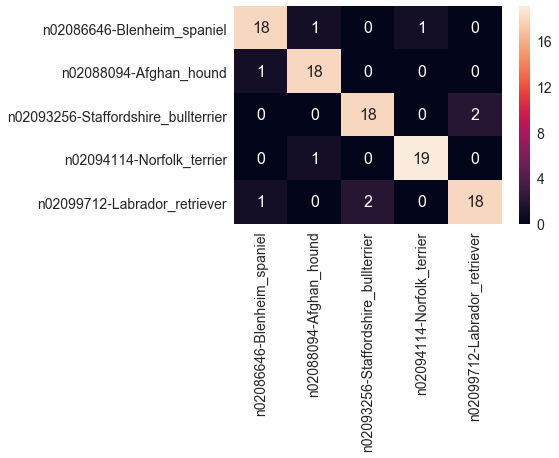

In [35]:
# Load best model
model = Sequential()
model.add(Flatten(input_shape=validation_data.shape[1:]))
model.add(Dense(space_eval(space, best)['dense'], activation='relu'))
model.add(Dropout(space_eval(space, best)['dropout']))
model.add(Dense(num_classes, activation='softmax'))

model.load_weights('fc_model_adam_3.h5')


labels = ['n02086646-Blenheim_spaniel', 
          'n02088094-Afghan_hound', 
          'n02093256-Staffordshire_bullterrier',
          'n02094114-Norfolk_terrier',
          'n02099712-Labrador_retriever']
y_pred = model.predict_classes(validation_data)
y_true = np.argmax(validation_labels, axis=1)
print("f1 score: ", f1_score(y_true, y_pred, average='micro'))
predictions =  [labels[i] for i in y_pred]
real = [labels[i] for i in y_true]
cm = confusion_matrix(predictions, real)
df_cm = pd.DataFrame(cm, index = labels,
                  columns = labels)
sn.set(font_scale=1.4)#for label size
sn.heatmap(df_cm, annot=True,annot_kws={"size": 16})

We also have improved, our model, let's choose it, that's our final model.

# 2. Select and test final model

In [36]:
top_model_weights_path = 'fc_model_adam_3.h5'

Now we can play with our model importing weigths we previously stored after having trained our model.

In [40]:
img_width, img_height = 224, 224
labels = ['n02086646-Blenheim_spaniel', 
          'n02088094-Afghan_hound', 
          'n02093256-Staffordshire_bullterrier',
          'n02094114-Norfolk_terrier',
          'n02099712-Labrador_retriever']

def predict(image_path):

    num_classes = 5

    orig = cv2.imread(image_path)

    print("[INFO] loading and preprocessing image...")
    image = load_img(image_path, target_size=(img_width, img_height))
    image = img_to_array(image)

    # important! otherwise the predictions will be '0'
    image = image / 255

    image = np.expand_dims(image, axis=0)

    # build the VGG16 network
    model = applications.VGG16(include_top=False, weights='imagenet')

    # get the bottleneck prediction from the pre-trained VGG16 model
    bottleneck_prediction = model.predict(image)

    # build top model
    model = Sequential()
    model.add(Flatten(input_shape=bottleneck_prediction.shape[1:]))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.6))
    model.add(Dense(num_classes, activation='softmax'))

    model.load_weights(top_model_weights_path)

    # use the bottleneck prediction on the top model to get the final
    # classification
    class_predicted = model.predict_classes(bottleneck_prediction)

    probabilities = model.predict_proba(bottleneck_prediction)

    inID = class_predicted[0]

    label = labels[inID]

    # get the prediction label
    print("Image ID: {}, Label: {}".format(inID, label))

In [41]:
predict('./api/image/afghanhoundsf4.jpg')

[INFO] loading and preprocessing image...
Image ID: 1, Label: n02088094-Afghan_hound
